# Assignment 2 -- ML4F 2021 -- Group 04

David Landveld - 2742120 - d.j.f.landveld@student.vu.nl

Mark de Kwaasteniet - 2649271 - m.g.de.kwaasteniet@student.vu.nl

Marc Peter van Gils - 2703225 - m.p.van.gils@student.vu.nl

### Modules

We will also run a reset to make sure that no dataframes, variables, and packages are stored from previous commands.

In [1]:
%reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sklearn
import seaborn as sns
import matplotlib as mpl
from math import sqrt

import matplotlib.ticker as ticker
import matplotlib.cm as cm

from kneed import KneeLocator
from yellowbrick.cluster import silhouette_visualizer

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import sklearn.metrics as sm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import tree
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import GridSearchCV

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Below we present a simple function that we use twice in question 2 when creating a plot for the Inertia and Silhouette.

In [2]:
def simple_plot(X,Y,title,xlabel,ylabel):
    plt.plot(X,Y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

## Introduction

The Paycheck Protection Program (PPP) gives support to companies who are negatively impacted by Covid-19 to pay their employees. Many businesses have been affected and the money was limited. This means the PPP cannot give all the companies money. The dataset provided contains the loans to different companies. It also contains the probability of default (`ProbabilityDefault`) as estimated by the loan officer.

Let's load and have a look at the data.

In [3]:
path = os.path.join('data','loans.xlsx')

df_data = pd.read_excel(path)

In [4]:
df_data.head(5)

,LoanAmount,City,State,Zip,NAICSCode,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,JobsRetained,DateApproved,Lender,CD,AgeLoan,ProbabilityDefault
0,20800,EAGLE,ID,83616,531210.0,Limited Liability Company(LLC),Unanswered,Unanswered,Unanswered,NaN,0.0,2020-07-04 00:00:00,Washington Trust Bank,ID - 01,117,1.250967
1,80000,HAYDEN,ID,83835,722511.0,Corporation,Asian,Female Owned,Unanswered,NaN,24.0,04/15/2020,Glacier Bank,ID - 01,230,6.033691
2,75500,IDAHO FALLS,ID,83401,811121.0,Subchapter S Corporation,White,Male Owned,Non-Veteran,NaN,7.0,2020-10-04 00:00:00,Bank of Idaho,ID - 02,236,2.334621
3,133500,POST FALLS,ID,83854,722211.0,Limited Liability Company(LLC),White,Unanswered,Unanswered,NaN,26.0,04/13/2020,First Interstate Bank,ID - 01,240,9.567953
4,8187,RIGBY,ID,83442,327991.0,Sole Proprietorship,White,Male Owned,Non-Veteran,NaN,1.0,2020-05-05 00:00:00,Beehive FCU,ID - 02,51,1.462785


##### Interpretation of Dataframe
Both numerical and categorical variables are observed in the dataframe. Additionally, the columns have missing values, incorrect values/strings and different notation methods. 
1. The missing values will not yet be tackled and will remain NaN, since we will determine how to impute them based on the later questions in the assignment. 


2. We locate the incorrect values by looking at the different datatypes and unique values. 

> Here we already see that the variable `LoanAmount` is an object when in fact it should be a numerical value. This indicates that there might be some incorrect inputs in this variable. Further investigation has led us to believe that some values contain a comma which converts them into an object instead of a integer.

3. By looking at the output of the describe function, we also find incorrect values by looking at min or max values.

> In this case, we find that there are high (above 100%) and negative probability of defaults present in the dataset. Both are not possible since the probability of default cannot be higher than 100% and it cannot be negative. Therefore, before transforming the data, we will manipulate this column and set the incorrect values equal to NaN. Just like before we let these incorrect values be NaN and check the distributions before imputing or dropping them. 

4. Lastly, the 'DateApproved' variable has different input methods. 

> Some strings contain the month/day/year time notation and some strings contain the year-month-day time notation. To make the data uniform, we transform this variable into a consistent Date variable.

In [5]:
#Remove the comma's from the strings in the LoanAmount column.
df_data['LoanAmount'] = df_data['LoanAmount'].replace(',', '.', regex=True).astype(float)

#Make the DateApproved Variable uniform over the whole column and convert to datetime64
df_data.DateApproved = pd.to_datetime(df_data['DateApproved']).dt.strftime('%Y-%m-%d').apply(pd.to_datetime)

# Question 1
(12 points)

### *Use the methods discussed so far to preprocess the data. Make some descriptive statistics and histograms etc to find out more about the distributions of the data. Are there NaNs, outliers etc? Then choose what preprocessing to apply and clearly explain your choices.*

Some of the variables in the dataframe have already been manipulated according to their data type. In the next step, we will again look at all the different datatypes to split the numerical variables from the categorical variables and to determine what categorical variables we would like to include in our model. 
- In the DataFrame (after manipulation) we find 5 numerical variables, excluding the ProbabilityDefault (target). We will use only three numerical variables as features, since the other two numerical variables are Zip and NAICSCode. These are numerical values that represent a category. I.e., the place of the company (Zip) and the industry the company is operating in (NAISCode). We cannot interpret these features similar to numerical features.


- In the DataFrame we find 10 categorical variables. However, not all of these variables are suited to be included in a prediction model as categorical variable, because there might be too many or too few categories to choose from. We inspect the number of categories by looping over each categorical variable and printing the number of unique strings in this column.

Categorical result of the for loop:
- City, State, NAICSCode, Lender are the columns that will be dropped from the feature set, because they have too many categories (>100) or too few categories (<2). *Zip will be excluded later since the variable is still needed for question 2.*


- The rest of the categorical variables will be stored in a list and will be transformed in to features. The categorical variables are transformed into features by creating dummy variables for every category in that variable (excluding one dummy due to multicollinearity problems). This creates a total dataframe consisting of 107 columns (including the target class ProbabilityDefault).

We select the target from the dataset and copy the total dataset into a dataframe in which we will transform the variables. This new The Paycheck Protection Program (PPP) dataframe also contains the target that we will use in question 2. 

In [6]:
target_name = 'ProbabilityDefault'

# `sr_` prefix stands for a pandas Series
sr_targets = df_data.loc[:,target_name]

# The Paycheck Protection Program dataframe
df_ppp = df_data.copy()

In [7]:
# Drop the variables that have too many or too few categories
drop_columns = ['NAICSCode', 'State', 'City', 'Lender']

df_ppp.drop(drop_columns, inplace=True, axis=1)

#### Distribution of the target
By creating a histogram of the target `ProbabilityDefault`, it is observed that the target has most of its probabilities around 0%-20%. Still there are some extreme outliers of 500% which we have touched upon at the desciptive statistics.

When looking at boxplots of all the numerical features/target, we primarily see that the following features/target have a lot of outliers: `ProbabilityDefault`, `JobsRetained` and `Zip`. We will process these features by clipping the outliers based on 4 standard deviations, after we've preprocessed the data using RobustScaler. 


#### Note:
It should be noticed that the distribution of `Zip` is also clipped for usage in Question 2. In Question 2, they ask us to incorporate the `Zip` feature, therefore we assume that we need to treat this feature as a numerical variable. Standardizing and clipping the `Zip` feature before the K-Means estimation. However, `Zip` is a categorical feature with numerical features, therefore removing outliers in this feature can be incorrect.

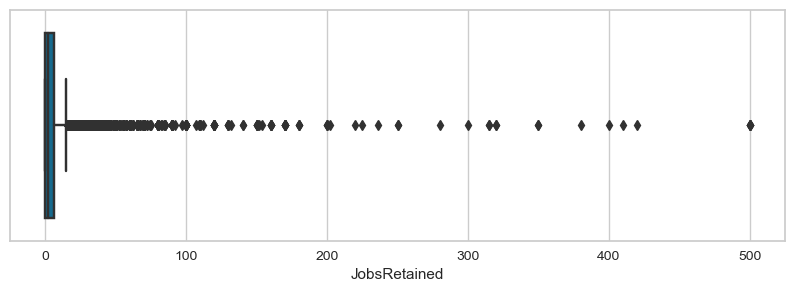

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 3)
sns.boxplot(x=df_ppp['JobsRetained'])
plt.show()

In [9]:
# Create dummy features for every category.
list_categories = ['BusinessType','RaceEthnicity','Gender','Veteran','NonProfit', 'CD', 'DateApproved'] 
df_ppp = pd.get_dummies(df_ppp, columns = list_categories, drop_first=True)

When we again look at the features in the dataset, we see that most of them are dummy variables that represent categories. We still have three numerical features that we might want to transform. Looking at the distributions, we see that both `LoanAmount` and `JobsRetained` are features that have positive skewness. In this case, a log transformation can be a useful transformation method, creating a more normal distribution. This will automatically scale the features as well. 

However, we only log transform the `LoanAmount` feature. This is because the `JobsRetained` feature contains some zero values that could have explanatory value. A log transformation would return this zero value to infinity, meaning that we would have to impute these zero values after the transformation. We don't want to do this since the zeroes could be meaningful to estimating the `ProbabilityDefault` target. 

After the Log Transformation of the `LoanAmount`, the three numerical features: `LoanAmount`, `JobsRetained` and `AgeLoan` are not yet in the same scale. Therefore, we also scale all the features using a standardization method.

#### Robust Standardization
By standardizing, every feature will have similar scales making it easier to compare the features. Furthermore, after the standardization, a certain percentile of the data can be easily removed using the standard deviation that is calculated. We choose standardization over normalization because standardization provides more useful info about the outliers in the dataframe (which is asked in the question).
 
In our case we use the RobustScaler of scikit, since it is more robust against outliers compared to the StandardScaler, meaning it scales the features according to the InterQuartileRange (0.25|0.75) of that feature. 

However, since this method is not immune to outliers, we still find some outliers in the histograms after the standardization. We want to remove these outliers to improve the generalisability of the logistic model that we are specifying later on.

We clip these outliers ourselves using 4 standard deviations relative to every feature. Meaning we replace all the values that are outside 0.01% and 99.99% of the distribution of a certain feature by NaN. We set them to NaN instead of winsorizing, to prevent certain features from having a large number of -4 and/or 4 values.

In [10]:
# LOG transformation of LoanAmount
df_ppp.LoanAmount = (np.log(df_ppp.LoanAmount)).replace(-np.inf, np.nan)

In [11]:
STD_OUTLIER = 4

df_ppp_std = df_ppp.copy()

#Standardize using RobustScaler
df_ppp_std[df_ppp_std.columns] = RobustScaler().fit_transform(df_ppp_std[df_ppp_std.columns])

#Convert values in the dataframe with a z-score < -4 or > 4 to NaN
df_ppp_std[(df_ppp_std < -STD_OUTLIER) | (df_ppp_std > STD_OUTLIER)] = np.nan

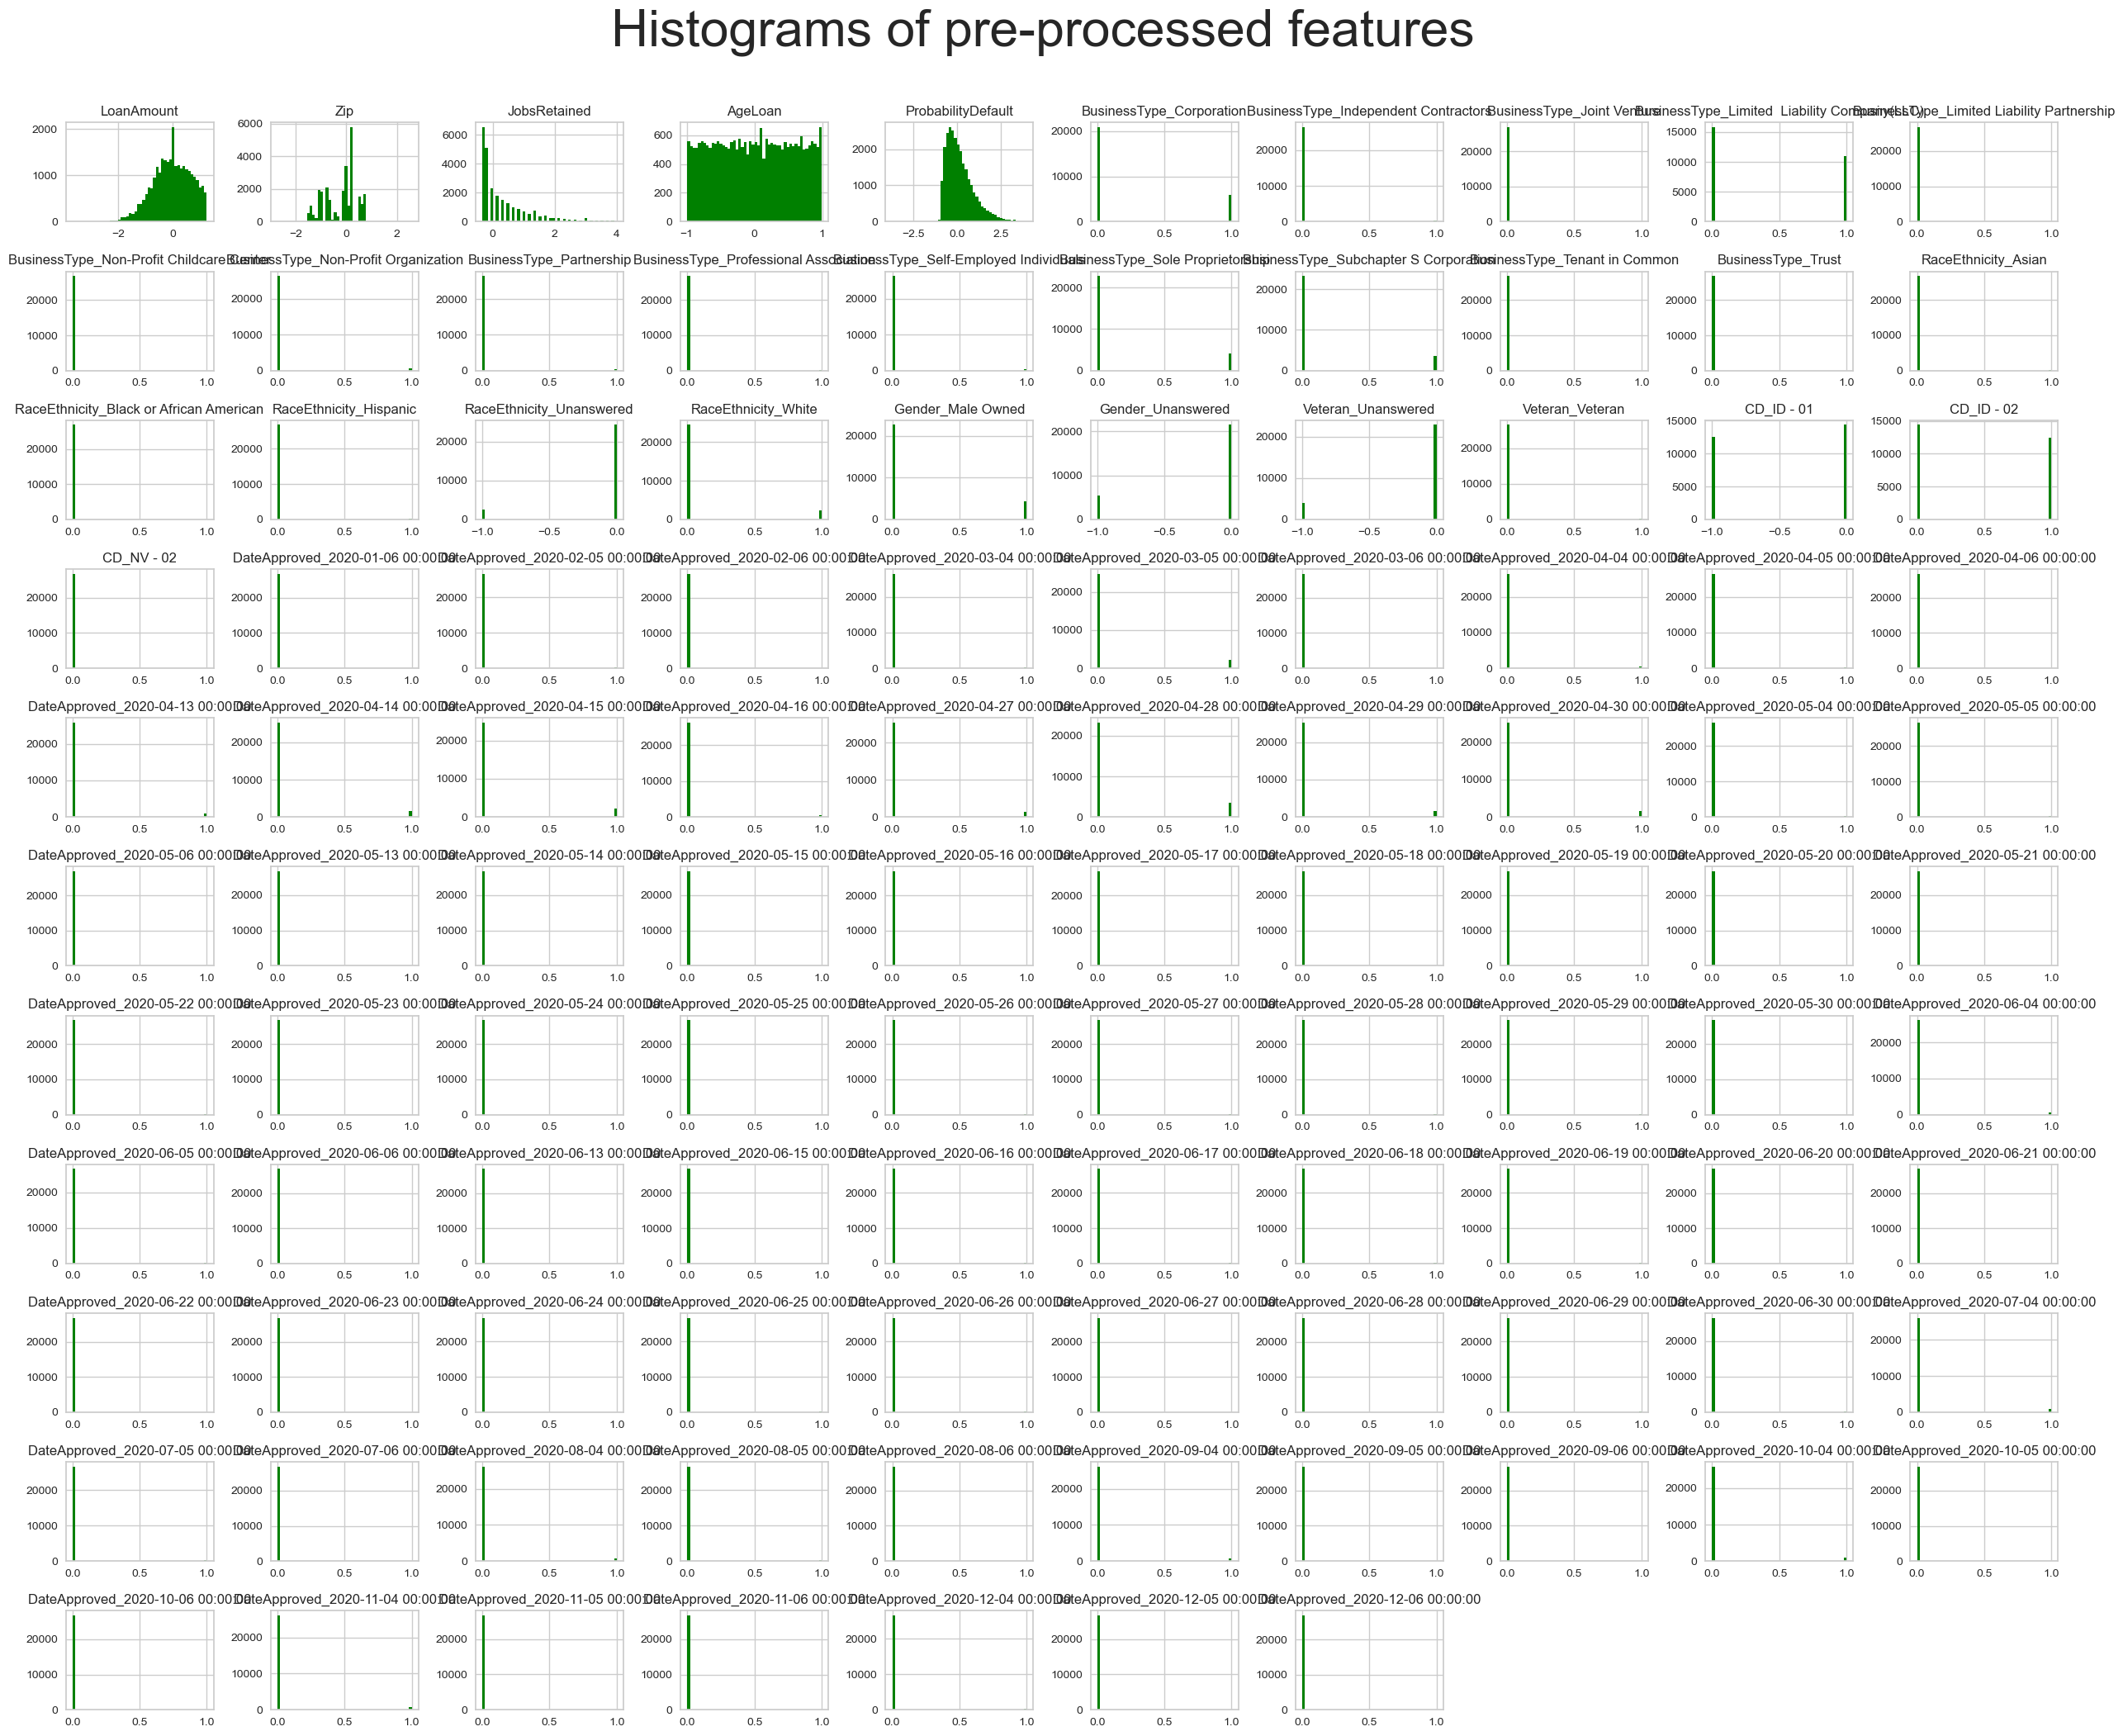

In [12]:
df_ppp_std.hist(bins=50, figsize=(25, 20), color = "green")
plt.tight_layout()   

plt.suptitle('Histograms of pre-processed features', x=0.5, y=1.05, ha='center', fontsize='45')
plt.show()

Here we see that the distribution of LoanAmount has drastically changed into a more normal distribution. We only standardized the other features and removed the outliers. However, since there weren't a lot of features with outliers (only JobsRetained had some outliers), the other 106 distributions are similar to the distributions before the standardization. 


# Question 2
(22 points)

### *Explain what a k-means model is.*

A K-Means model is a machine learning algorithm that tries to classify unlabeled data. It is an unsupervised method to predict/find groups (clusters) within the data. The algorithm identifies a number ($k$) of so-called centroids which are centers of clusters of data. It starts by picking random centroids and, since the identification process is iterative, it only stops when the clustering is a success (there is no better position for the centroids) or when the maximum number of iterations is reached. The performance metric of a k-means model is inertia which is the mean squared distance to the closest centroid. Together with the silhouette, calculated by $\frac{(b-a)}{max(a,b)}$ (where $a$ is the mean intra-cluster distance and $b$ is the mean distance to the next cluster), the right number of clusters can be determined.


### *Estimate a k-means model with 3 clusters for the variables `LoanAmount`, `Zip`, `ProbabilityDefault` and `AgeLoan`.*

For creating a k-means model, a part of the dataframe is extracted since we have to use all features in question 3-5. Therefore, we only work with a Kmeans Dataframe in Question 2. 

KMeans uses a distance-based measurements to determine the similarity between data points. Therefore, it is important that all the variables in the K-Means model have comparable units. In that case the distance measure on which the measurement is based, will be in similar units across the four variables. That is why we will work with the standardized dataframe, that we've produced in question 1. 

In [13]:
#Keep columns of interest in the dataframe.
columns_interest = ['LoanAmount', 'Zip', 'AgeLoan', 'ProbabilityDefault']
df_kmeans = df_ppp_std.copy()
df_kmeans = df_kmeans[columns_interest]

After extracting only the columns of interest, the number of NaN values in the DataFrame is checked since we cannot estimate a k-means model with NaN values in the data. The following amount of of NaN's can be found in output below. 

Since the amount of NaN's are relatively low compared to the total number of observations, the decision has been made to drop the rows with NaN values as this will have little impact on the estimation.

In [14]:
print(df_kmeans.isna().sum())
df_kmeans = df_kmeans.dropna()

LoanAmount             0
Zip                    4
AgeLoan                0
ProbabilityDefault    32
dtype: int64


Then, the k-means model is estimated with 3 clusters using the scikit learn cluster package: KMeans. We estimate the k-means model using the default input for the `n_init` and `max_iter` parameters, so the estimation won't be taking too much time.

In [15]:
kmeans_ppp = KMeans(n_clusters=3, random_state=0)
kmeans_ppp.fit(df_kmeans)
pred_kmeans = kmeans_ppp.predict(df_kmeans)

To give an indication of the predicted clusters of the estimated K-Means model we plot the clusters in two dimensions. Only using LoanAmount and Ageloan, since we aren't able to plot in four dimensions.

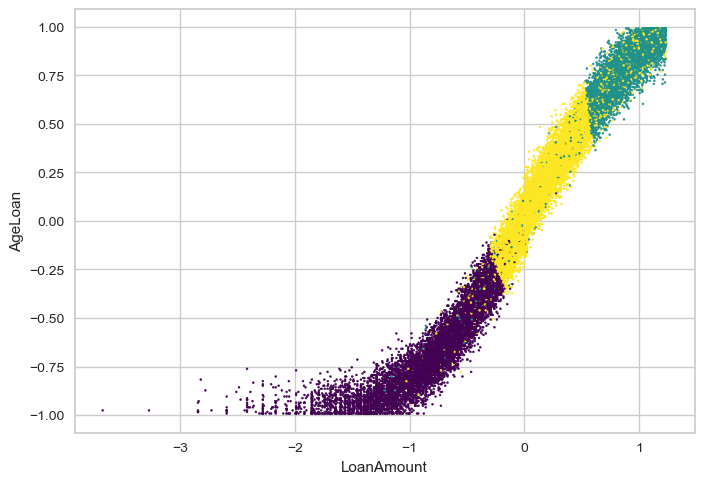

In [16]:
plt.scatter(df_kmeans.iloc[:, 0], df_kmeans.iloc[:, 2], c=pred_kmeans, s=2, cmap='viridis')
plt.xlabel("LoanAmount")
plt.ylabel("AgeLoan")
plt.show()

### *Determine with the elbow method with inertia what the right number of clusters is. Please plot the inertia and explain your choice of clusters.*

We use the same K-means estimation process (with the same parameter inputs), but repeat this for multiple clusters to determine what the optimal number of clusters is. Using the KneeLocator function, the right number of clusters according to inertia is found (4).

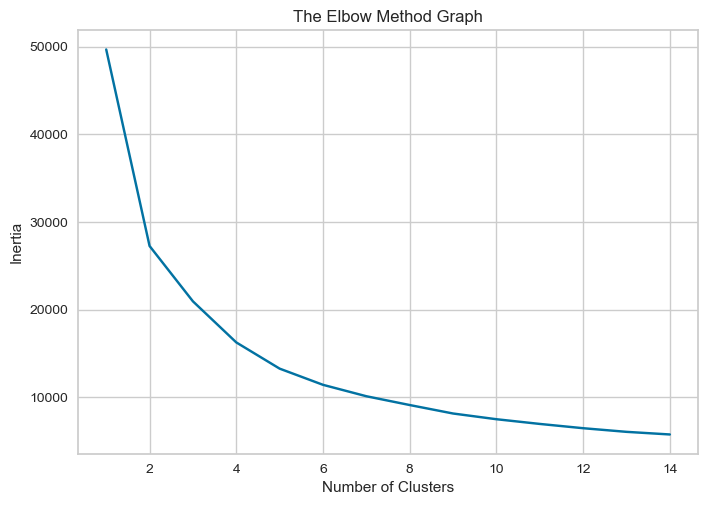

The optimal number of clusters is 4


In [17]:
#Storing the weighted sum of squared differences to the centroids.
Inertia=[]

cluster_range = range(1,15)

for clusters in cluster_range: 
    kmeans_ppp = KMeans(n_clusters=clusters, random_state=0)
    kmeans_ppp.fit(df_kmeans)
    Inertia.append(kmeans_ppp.inertia_)

simple_plot(cluster_range, Inertia, "The Elbow Method Graph", "Number of Clusters", "Inertia")

Elbow_point = KneeLocator(cluster_range,Inertia, curve="convex", direction="decreasing").knee
print('The optimal number of clusters is ' + str(round(Elbow_point,2)))

### *Do the same but this time using the silhouette score. Compare both. Would you now reconsider your choice of the previous question?*

First, the silhouette score for multiple cluster options is calculated. Then we use a similar plot to determine what the optimal number of clusters is. For time saving purposes, a plot is created for n_cluster 2 till 7. 


*Result:* The resulting silhouette plot indicates that 2 clusters would be the optimal amount, which is contradicting the inertia plot above. This makes us reconsider the answer on the previous question. 

To be completely certain of the optimal number of clusters we created Silhouette Diagrams of clustering on $k$ = 2,4 or 5 (Since these give the highest silhouette score). These diagrams give a bit more detail about the distributions of the clusters.

#### Silhouette Score Graph

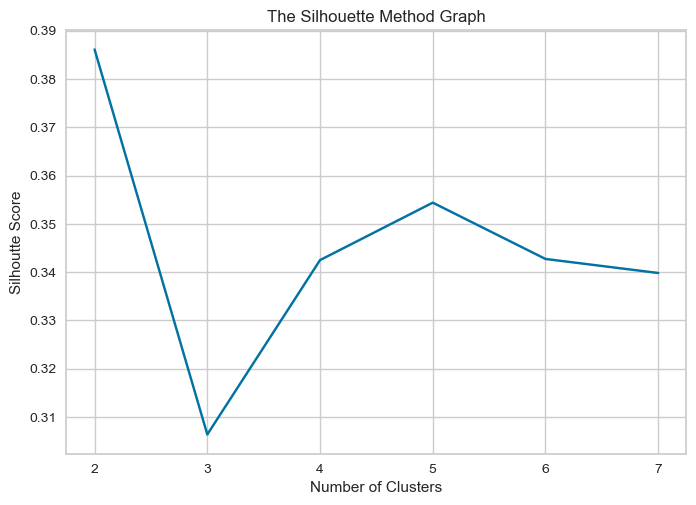

In [18]:
Silhouette_Scores = []

cluster_range = range(2,8)

for clusters in cluster_range: 
    kmeans_ppp = KMeans(n_clusters=clusters, random_state=0)    
    kmeans_pred = kmeans_ppp.fit_predict(df_kmeans)
    Silhouette_Scores.append(silhouette_score(df_kmeans, kmeans_pred))

simple_plot(cluster_range, Silhouette_Scores, "The Silhouette Method Graph", "Number of Clusters", "Silhoutte Score")

#### Silhouette Diagram

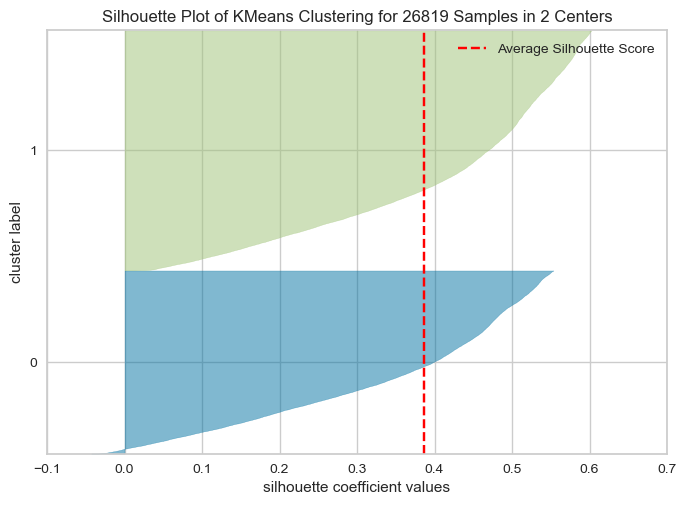

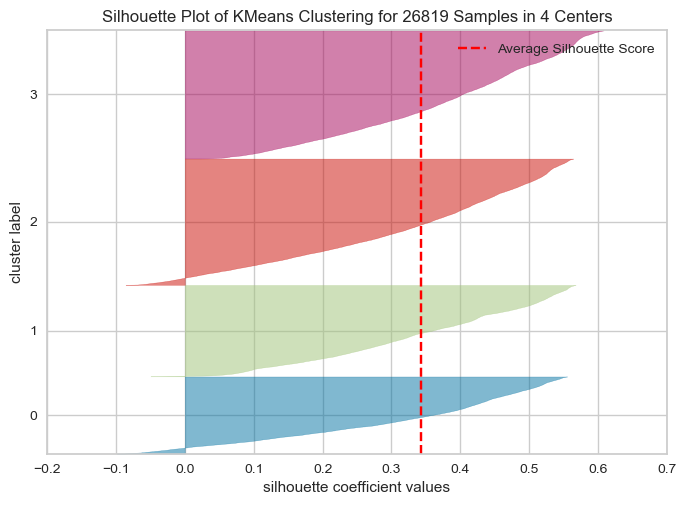

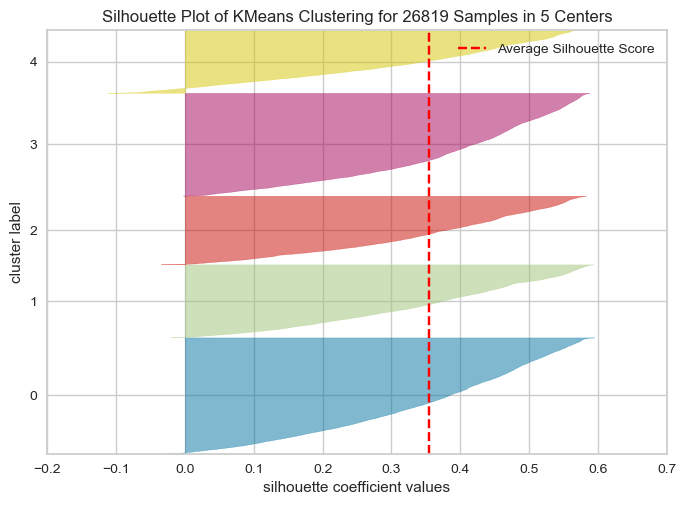

In [19]:
cluster_range = [2,4,5]

for clusters in cluster_range: 
    # Use the quick method and immediately show the figure
    silhouette_visualizer(KMeans(clusters, random_state=0), df_kmeans,  colors='yellowbrick')

#### Conclusion of question 2
Even though using two clusters has a higher silhouette score, the conclusion from the silhouette diagrams is that the features are more equally distributed using 4 or 5 clusters. These silhoutte diagrams are in line with the conclusion from the elbow graph, showing that we should stick with 4 clusters.

# Question 3

(22 points)

### *Mention one advantage and one disadvantage of using Principal Component Analysis (PCA).*

#### Advantage
Principal Component Analysis is an effective method to create explanatory features in a high dimensional dataset. By scaling the dimensions of the data to a certain amount ($k$), the analysis will create new features which are a combination of the existing features in the dataset. Therefore, the advantage of PCA that it is a very effective method to reduce the number of features in a model. Thus creating a more parsimonious model with independent principal components that could even improve model performance. 
#### Disadvantage
Since Principal Component Analysis creates features out of the original features from the dataset, it is much harder to interpret the principal components (newly created features). Because the principal components consists of a certain combination of initial features, the first principal component could be based on 10% of all the initial features, making it very complicated to interpret.

### *Reduce the dataset to two dimensions with PCA and make a clear plot. Make sure to label all the important information.*

For both the features and the target, we will fill all the NaN values with the mean.
1. There are very few NaN values in the column `ProbabilityDefault`, meaning that the predictions won't be biased if we imput the target with the mean.
2. We use will use a DecisionTreeRegressor and not a Classifier, meaning we can impute the features and the targets with the mean, since this won't affect the coefficients but still enables us to use rows of other features that don't have NaN values.

Then we split the dataset in targets and features. In the dataset of the features we make sure to impute the mean for the nan values. 

In [20]:
#Fill all NaN with the mean of their column.
df_ppp_std = df_ppp_std.fillna(df_ppp_std.mean())

# Split target and features.
sr_targets_std = df_ppp_std.loc[:,target_name]
sr_features_std = df_ppp_std.drop([target_name],axis=1)

#differtiate between categorical and numerical features
list_num = ['LoanAmount', 'JobsRetained', 'AgeLoan']
sr_features_cat_std = sr_features_std.drop(list_num, axis=1)
sr_features_num_std = sr_features_std[list_num]

For the PCA, we only use the `sr_features_num_std` dataframe, which contains only the numerical features and is excluded from the target.

In [21]:
NUMBER_COMPONENTS = 2

pca = PCA(n_components=NUMBER_COMPONENTS)
df_pca = pca.fit_transform(sr_features_num_std)

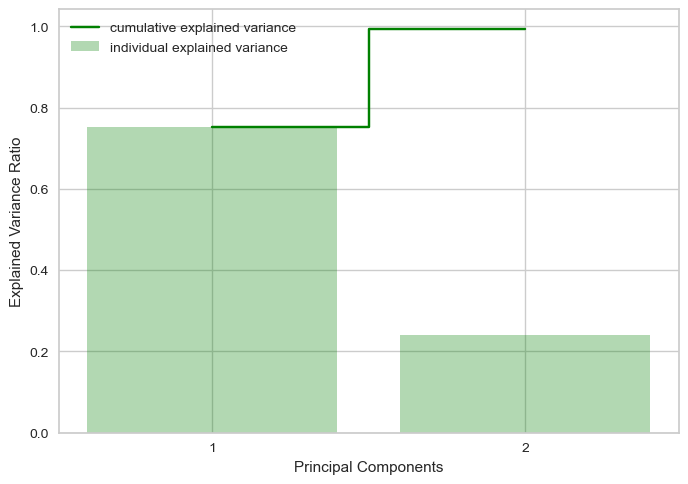

In [22]:
# print(pca.explained_variance_ratio_)
plt.bar(range(1,NUMBER_COMPONENTS+1), pca.explained_variance_ratio_, alpha=0.3, label='individual explained variance', color = "green")
plt.step(range(1,NUMBER_COMPONENTS+1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='cumulative explained variance', color = "green")
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.legend(fontsize='small')
plt.xticks([1,2])
plt.show()

### Interpretation

So far we see that choosing two Principal Components will have a Cumulative Explained Variance Ratio of roughly 100%. To visualise the PCA method's created features, a figure is created below with the PCA and TSNE comparison. 

### *This time reduce the dataset to two dimensions with t-SNE and make a clear plot.*

Below, we create and fit the TSNE features. For time saving purposes, we set the number of iteration equal to 300. A minimum of 250 is required. 

In [23]:
features_embedded = TSNE(n_components=2, n_iter=300).fit_transform(sr_features_num_std)

In order to be able to clearly see which groups/clusters are formed by both methods, we classify the 'ProbabilityDefault' Target Variable.

#### Note:
We don't actually know what is consider a high or low probability. We have created seven labels, ranging from extremely low to extremely high based on the total distribution of the dataset. We do this by dividing the data into seven discrete intervals. The creation of this target classification is only for visualization purposes. 

In [24]:
labels_group=['Extremely Low','Very Low', 'Low', 'Average', 'High', 'Very High', 'Extremely High']

sr_features_num_std = sr_features_num_std.assign(default_group = pd.cut(sr_targets_std, 7, labels=labels_group))

In [25]:
#new columns are created for PCA and t-SNE for our plotting package to use
sr_features_num_std = sr_features_num_std.assign(PCA_1 = df_pca[:,0])
sr_features_num_std = sr_features_num_std.assign(PCA_2 = df_pca[:,1])

sr_features_num_std =  sr_features_num_std.assign(TSNE_1 = features_embedded[:,0])
sr_features_num_std = sr_features_num_std.assign(TSNE_2 = features_embedded[:,1])

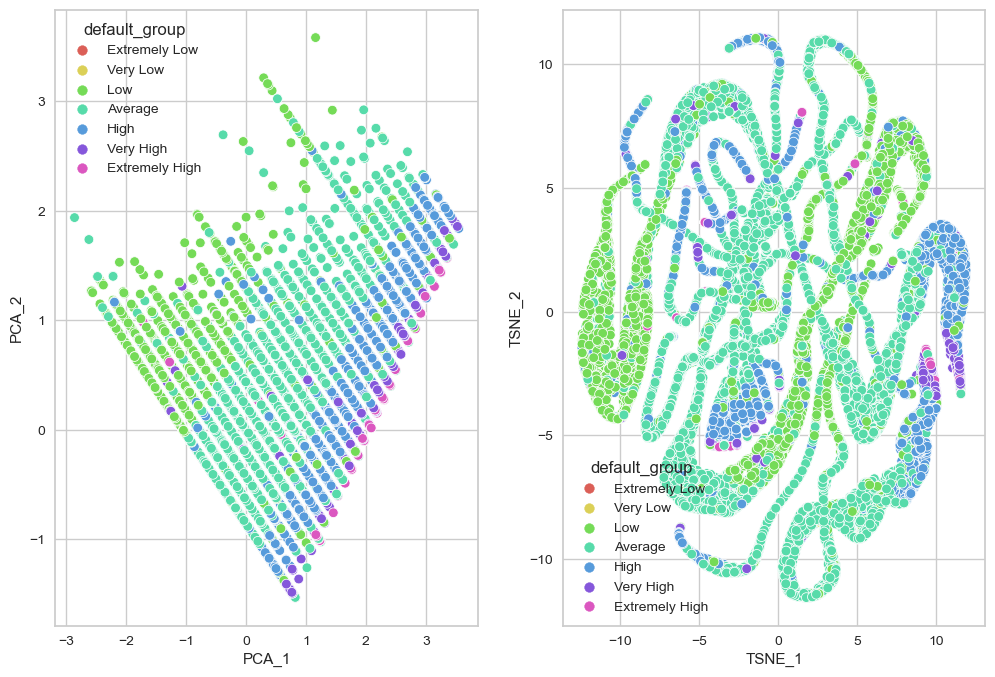

In [26]:
plt.figure(figsize=(12,8))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="PCA_1", y="PCA_2", hue="default_group",
    palette=sns.color_palette("hls", n_colors=7),
    data=sr_features_num_std,
    legend="full",
    ax=ax1
)
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="TSNE_1", y="TSNE_2", hue="default_group",
    palette=sns.color_palette("hls", n_colors=7),
    data=sr_features_num_std,
    legend="full",
    ax=ax2
)
plt.show()

### *Explain whether PCA or t-SNE is better to use with this particular data set.*

Both methods are unsupervised learning techniques, meaning they can learn/work with unlabeled data. Furthermore, PCA is linear and t-SNE is non-linear. 

Looking at the graph, you can see that the t-SNE is better at creating seperate groups of observations, however it fails to distinguish groups of default probability. In the PCA plot it is much easier to see the where the default_groups datapoints form a group. Furthermore, PCA is a deterministic method, meaning that it doesn't have parameters to initialize and it doesn't have to deal with the problem of different local minima.
Therefore, it is better to use PCA in this particular data set.


# Question 4

(22 points)

### *Add the two columns you made with PCA to the dataset. Then pick a Decision Tree model and train a good model to predict the Probability of Default (`ProbabilityDefault`). It is not necessary to tune the hyperparameters (so the default settings are fine).*

In [27]:
sr_features_num_std = sr_features_num_std.drop(['TSNE_1', 'TSNE_2', 'default_group'] ,axis=1)
sr_tot_features_std = sr_features_num_std.join(sr_features_cat_std)

#Zip excluded since this is in origin a categorical variable, with too many categories.
sr_tot_features_std = sr_tot_features_std.drop(['Zip'],axis=1)

#Impute missing values
sr_tot_features_std = sr_tot_features_std.fillna(sr_tot_features_std.mean())
sr_targets_std = sr_targets_std.fillna(sr_targets_std.mean())

For splitting the dataset in a training and test set, we use the 80/20 rule. This means we select 80% of our dataframe for training the model and 20% of our dataframe for testing the model. We use the 80/20 rule instead of the 70/30 rule because the latter is often used for datasets of a million rows, and our current dataset is thus too small. 

In [28]:
SPLIT_SIZE = 0.2
COSTANT_SPLIT = 0

features_train,features_test,targets_train,targets_test=train_test_split(sr_tot_features_std,sr_targets_std,
    test_size=SPLIT_SIZE,random_state=COSTANT_SPLIT)

#Train a model and predict
clf = tree.DecisionTreeRegressor().fit(features_train, targets_train)
targets_pred = clf.predict(features_test)


### *Explain how well your model performs. Do you think the predictions are any good?*

In [29]:
#A function for the two performance metrics considered
def score_metrics(type_data, y_test, y_pred):

    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    r2 = r2_score(y_test,y_pred)
    
    print('The ' + type_data + ' Statistics on the test set:')
    print('The R-Squared is ' + str(round(r2,4)))
    print('The Root Mean Squared Error is ' + str(round(rmse,4)))

In [30]:
score_metrics("Test", targets_test, targets_pred)

The Test Statistics on the test set:
The R-Squared is 0.278
The Root Mean Squared Error is 0.6705


#### Interpretation
The two model performance metrics above are the the R-squared and the Root Mean Squared Error (RMSE). The R-squared shows that the model predictions do not fit the test data to a high extend since the value is low with only 0.2809 (low explanatory power). The RMSE, preferably as low as possible, is the prediction error and is considered too high to classify the prediction as good.

# Question 5

(22 points)

### *This question turns on how to tune hyperparameters. Please compute what you consider the best choice for "splitter", "max_depth", and "min_samples_leaf" (jointly).*

Using GridSearch, the splitter, max_depth, and min_samples_leaf parameters of DecisionTreeRegressor are tweaked in order to find the best possible combination of the three. The choice has been made to do this to find the a maximum score for the performance metric R-squared. The GridSearch tuning algorithm uses, next to this R-squared score, a 5-fold cross validation. 

We determined these scores after trying random values and narrowing down to a select group of hyperparameter values which would be best. 

In [31]:
#Initialize GridSearch Parameters:
params={"splitter":["best","random"],
            "max_depth" : [3,4,5,6,7],
           "min_samples_leaf":[1,2,3,4,5,6]
           }
decision_tree = tree.DecisionTreeRegressor()

tuned_model = GridSearchCV(decision_tree,param_grid=params,scoring='r2',cv=5)
tuned_model.fit(sr_tot_features_std,sr_targets_std)

print("The optimal Hyperparameters are: " + str(tuned_model.best_params_))

The optimal Hyperparameters are: {'max_depth': 5, 'min_samples_leaf': 6, 'splitter': 'best'}


In [32]:
#Re-estimated/train the decision tree regressor with the new tuned Hyperparameters
tuned_tree = tree.DecisionTreeRegressor(**tuned_model.best_params_)
tuned_tree.fit(features_train,targets_train)

#Predict the probility of default with the trained newly tuned model.
tuned_pred = tuned_tree.predict(features_test)

In [33]:
score_metrics("Test", targets_test, tuned_pred)

The Test Statistics on the test set:
The R-Squared is 0.644
The Root Mean Squared Error is 0.4708


### *Does your hyperparameter tuning does lead to overfitting? Provide arguments.*

If the hyperparameter tuning would have led to overfitting, then the measurement statistics on the predictions (test set) of the tuned model would be worse compared to the previous model in Question 4. This is not the case.

The hyperparameter tuning has led to a much better fit on the test data and a worse fit on the training data. The R-squared score of the model on the training set and the testing set do not differ that much. This means that our hyperparameter tuning did not led to overfitting, since it has led to a better R-Squared and RMSE on the test set.

### *Explain whether you consider the hyperparameter tuning useful (given amongst others the compute time, precision, other considerations, etc.).*

As explained before, the R-squared score improved significantly from 0.2783 to 0.644. Besides, the Root Mean Squared Error decreased from 0.6704 to 0.4708. Together with the fact that it did not let to overfitting, the tuning can be considered useful for performance purposes. 

However, tuning the hyperparameter took a lot of time when the larger lists were used. Initially it took us 4 minutes to have the above-mentioned parameter values. We've also tried to further enhance the model predictions by tuning additional hyperparameters, which took us about 30 minutes and left us with little improvement.

Overall, we would definitely consider tuning the hyperparameters usefull, but doing it with a relatively small number of rough parameter estimates to prevent long computing times that result in little to no model improvement.

---